In [1]:
import os

os.chdir("..")

In [167]:
# Select GPUs to use
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7'

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.auto import tqdm
import warnings
import random
import time
import datetime

# Evaluation
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix
)

# Transformers
import torch
from torch.nn import BCEWithLogitsLoss, DataParallel
from torch.utils.data import TensorDataset, DataLoader
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup # needed?

warnings.filterwarnings("ignore")

from src.models.evaluation import evaluation
from src.data.iterative_train_test_split import iterative_train_test_split

In [169]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [170]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

## 1. Load and transform data

In [171]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,ORG ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH ORG IS ONE OF THE WORLDS LEADING O...,org org annual report account year strong growth org one world leading online betting gaming com...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,sustainability report company profile corporate overview purpose mission value sustainability co...
8140,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,sustainability report investing future world letter ceo stakeholder company profile corporate ov...


In [172]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [379]:
# Split into 70% training, 15% validation, and 15% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_clean'], Y, test_size=0.3)
X_val, Y_val, X_test, Y_test = iterative_train_test_split(X_test, Y_test, test_size=0.5)

In [380]:
# Load tokenizer
tokenizer = LongformerTokenizerFast.from_pretrained("allenai/longformer-base-4096")

In [381]:
# Encode data (LongformerForSequenceClassification automatically sets global_attention_mask such that global attention is on the CLS token, no need to specify)
train_encodings = tokenizer(list(X_train), max_length=4096, truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(list(X_val), max_length=4096, truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(list(X_test), max_length=4096, truncation=True, padding=True, return_tensors="pt")

In [382]:
# Check encoding example

# Print the original sentence.
print('Original: ', X_train[3][1998:2051])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(X_train[3][1998:2051]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X_train[3][1998:2051])))

Original:  enthusiastic approach to sustainability and our drive
Tokenized:  ['ent', 'hus', 'i', 'astic', 'Ġapproach', 'Ġto', 'Ġsustainability', 'Ġand', 'Ġour', 'Ġdrive']
Token IDs:  [1342, 25134, 118, 11599, 1548, 7, 11128, 8, 84, 1305]


In [425]:
# Convert data into TensorDatasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(Y_train).float())
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(Y_val).float())
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(Y_test).float())

In [426]:
# Create the DataLoader

batch_size = 2
    
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle = True)

In [385]:
# Check DataLoader
next(iter(train_dataloader))

[tensor([[    0,   250, 25714,  ..., 47142,   544,     2],
         [    0,  3411,   534,  ...,    14,    51,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([[0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.],
         [0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]])]

## 2. Load model

In [427]:
# Use GPU
torch.cuda.empty_cache()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [428]:
# Load model
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", problem_type="multi_label_classification", num_labels=13)
# Multiprocessing
#model = DataParallel(model)
model.to(device)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weig

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (val

## 3. Train

In [429]:
# Define helper functions

# Function to calculate the macro F1-score of our predictions vs labels
def macro_f1(preds, labels):
    predicted_labels = torch.round(torch.sigmoid(torch.Tensor(preds))).numpy().astype(int)
    labels = labels.astype(int)
    return f1_score(predicted_labels, labels, average='macro')

# Function to format a time in seconds into a string hh:mm:ss
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the weights for the positive class
def calculate_pos_weights(labels):
    pos_counts = labels.sum(axis=0)
    neg_counts = len(labels) - pos_counts
    pos_weights = neg_counts / (pos_counts + 1e-5)
    return torch.as_tensor(pos_weights, dtype=torch.float)

In [430]:
# Prepare training

# Number of training epochs
epochs = 4

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Calculate the weights for the positive class for the training data
pos_weight = calculate_pos_weights(Y_train)

# Training with BCEWithLogitsLoss instead of CrossEntropyLoss()
loss_fct_train = BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
loss_fct_val = BCEWithLogitsLoss()

In [390]:
# Training

# Store training and validation loss, validation F1 score, and timings
training_stats = []

# Measure the total training time for the whole run
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes
    t0 = time.time()

    # Reset the total loss for this epoch
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch) and return the loss (because we provided labels) and the logits
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        logits = result.logits
        loss = loss_fct_train(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0. to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode (the dropout layers behave differently during evaluation)
    model.eval()

    # Tracking variables 
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Unpack this training batch from our dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            # Forward pass, calculate logit predictions
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model
        logits = result.logits
        loss = loss_fct_val(logits, b_labels)
            
        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the macro F1 score for this batch of test sentences, and accumulate it over all batches
        total_eval_f1 += macro_f1(logits, label_ids)
        

    # Report the final macro F1 score for this validation run
    avg_val_f1 = total_eval_f1 / len(val_dataloader)
    print("  Macro F1 score: {0:.2f}".format(avg_val_f1))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Macro F1 score.': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  2,778.    Elapsed: 0:02:34.
  Batch   200  of  2,778.    Elapsed: 0:05:05.
  Batch   300  of  2,778.    Elapsed: 0:07:36.
  Batch   400  of  2,778.    Elapsed: 0:10:08.
  Batch   500  of  2,778.    Elapsed: 0:12:39.
  Batch   600  of  2,778.    Elapsed: 0:15:09.
  Batch   700  of  2,778.    Elapsed: 0:17:39.
  Batch   800  of  2,778.    Elapsed: 0:20:10.
  Batch   900  of  2,778.    Elapsed: 0:22:41.
  Batch 1,000  of  2,778.    Elapsed: 0:25:13.
  Batch 1,100  of  2,778.    Elapsed: 0:27:44.
  Batch 1,200  of  2,778.    Elapsed: 0:30:14.
  Batch 1,300  of  2,778.    Elapsed: 0:32:44.
  Batch 1,400  of  2,778.    Elapsed: 0:35:15.
  Batch 1,500  of  2,778.    Elapsed: 0:37:46.
  Batch 1,600  of  2,778.    Elapsed: 0:40:16.
  Batch 1,700  of  2,778.    Elapsed: 0:42:48.
  Batch 1,800  of  2,778.    Elapsed: 0:45:19.
  Batch 1,900  of  2,778.    Elapsed: 0:47:50.
  Batch 2,000  of  2,778.    Elapsed: 0:50:21.
  Batch 2,100  of

In [391]:
# Look at training summary

# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Macro F1 score.,Training Time,Validation Time
epoch,,,,,
1,0.692967,0.630734,0.251873,1:10:31,0:04:10
2,0.664254,0.608726,0.389314,1:13:43,0:04:44
3,0.663815,0.617963,0.328027,1:15:18,0:04:17
4,0.660628,0.630710,0.061125,1:11:11,0:04:00


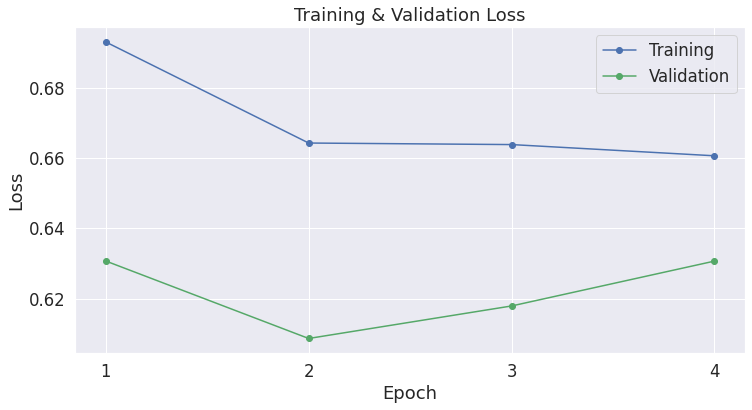

In [392]:
# Plot training and validation loss

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## 4. Predict on test set

In [393]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(X_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
    
    # Unpack this testing batch from our dataloader and copy each tensor to the GPU
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
  
    # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training)
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)
    # Get the logits output
    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,320 test sentences...
    DONE.


In [394]:
# Transform output for classification report
predicted_labels = torch.round(torch.sigmoid(torch.Tensor(np.concatenate(predictions, axis=0)))).numpy().astype(int)
true_labels = np.concatenate(true_labels, axis=0).astype(int)

In [395]:
# Print classification report
print(classification_report(predicted_labels, true_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       1.00      0.70      0.83      1320
          12       0.00      0.00      0.00         0

   micro avg       0.10      0.70      0.17      1320
   macro avg       0.08      0.05      0.06      1320
weighted avg       1.00      0.70      0.83      1320
 samples avg       0.09      0.70      0.16      1320



# BCEwithlogitsloss without pos_weight

In [406]:
# Training

# Store training and validation loss, validation F1 score, and timings
training_stats = []

# Measure the total training time for the whole run
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes
    t0 = time.time()

    # Reset the total loss for this epoch
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch) and return the loss (because we provided labels) and the logits
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        logits = result.logits
        loss = loss_fct_val(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0. to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode (the dropout layers behave differently during evaluation)
    model.eval()

    # Tracking variables 
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Unpack this training batch from our dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            # Forward pass, calculate logit predictions
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model
        logits = result.logits
        loss = loss_fct_val(logits, b_labels)
            
        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the macro F1 score for this batch of test sentences, and accumulate it over all batches
        total_eval_f1 += macro_f1(logits, label_ids)
        

    # Report the final macro F1 score for this validation run
    avg_val_f1 = total_eval_f1 / len(val_dataloader)
    print("  Macro F1 score: {0:.2f}".format(avg_val_f1))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Macro F1 score.': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch   100  of  2,778.    Elapsed: 0:02:33.
  Batch   200  of  2,778.    Elapsed: 0:05:07.
  Batch   300  of  2,778.    Elapsed: 0:07:45.
  Batch   400  of  2,778.    Elapsed: 0:10:21.
  Batch   500  of  2,778.    Elapsed: 0:12:58.
  Batch   600  of  2,778.    Elapsed: 0:15:37.
  Batch   700  of  2,778.    Elapsed: 0:18:16.
  Batch   900  of  2,778.    Elapsed: 0:23:22.
  Batch 1,000  of  2,778.    Elapsed: 0:25:55.
  Batch 1,100  of  2,778.    Elapsed: 0:28:27.
  Batch 1,200  of  2,778.    Elapsed: 0:30:59.
  Batch 1,300  of  2,778.    Elapsed: 0:33:32.
  Batch 1,400  of  2,778.    Elapsed: 0:36:11.
  Batch 1,500  of  2,778.    Elapsed: 0:38:48.
  Batch 1,600  of  2,778.    Elapsed: 0:41:24.
  Batch 1,700  of  2,778.    Elapsed: 0:44:04.
  Batch 1,800  of  2,778.    Elapsed: 0:46:35.
  Batch 1,900  of  2,778.    Elapsed: 0:49:08.
  Batch 2,000  of  2,778.    Elapsed: 0:51:43.
  Batch 2,100  of  2,778.    Elapsed: 0:54:17.
  Batch 2,200  of

In [407]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(X_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
    
    # Unpack this testing batch from our dataloader and copy each tensor to the GPU
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
  
    # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training)
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)
    # Get the logits output
    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,320 test sentences...
    DONE.


In [408]:
# Transform output for classification report
predicted_labels = torch.round(torch.sigmoid(torch.Tensor(np.concatenate(predictions, axis=0)))).numpy().astype(int)
true_labels = np.concatenate(true_labels, axis=0).astype(int)

In [409]:
# Print classification report
print(classification_report(predicted_labels, true_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.82      0.90      1320
           2       1.00      0.80      0.89      1320
           3       1.00      0.74      0.85      1320
           4       1.00      0.76      0.87      1320
           5       1.00      0.73      0.85      1320
           6       1.00      0.67      0.80      1320
           7       0.00      0.00      0.00         0
           8       1.00      0.85      0.92      1320
           9       1.00      0.62      0.77      1320
          10       0.00      0.00      0.00         0
          11       1.00      0.70      0.83      1320
          12       0.00      0.00      0.00         0

   micro avg       0.91      0.75      0.82     11880
   macro avg       0.69      0.52      0.59     11880
weighted avg       1.00      0.75      0.85     11880
 samples avg       0.92      0.75      0.80     11880



# FocalLoss

In [431]:
# https://www.kaggle.com/thedrcat/focal-multilabel-loss-in-pytorch-explained

num_label = 13

def focal_binary_cross_entropy(logits, targets, gamma=2):
    l = logits.reshape(-1)
    t = targets.reshape(-1)
    p = torch.sigmoid(l)
    p = torch.where(t >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = num_label*loss.mean()
    return loss

In [432]:
# Training

# Store training and validation loss, validation F1 score, and timings
training_stats = []

# Measure the total training time for the whole run
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes
    t0 = time.time()

    # Reset the total loss for this epoch
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch) and return the loss (because we provided labels) and the logits
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        logits = result.logits
        loss = focal_binary_cross_entropy(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0. to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode (the dropout layers behave differently during evaluation)
    model.eval()

    # Tracking variables 
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Unpack this training batch from our dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            # Forward pass, calculate logit predictions
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model
        logits = result.logits
        loss = focal_binary_cross_entropy(logits, b_labels)
            
        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the macro F1 score for this batch of test sentences, and accumulate it over all batches
        total_eval_f1 += macro_f1(logits, label_ids)
        

    # Report the final macro F1 score for this validation run
    avg_val_f1 = total_eval_f1 / len(val_dataloader)
    print("  Macro F1 score: {0:.2f}".format(avg_val_f1))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Macro F1 score.': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  2,778.    Elapsed: 0:01:51.
  Batch   200  of  2,778.    Elapsed: 0:03:42.
  Batch   300  of  2,778.    Elapsed: 0:05:33.
  Batch   400  of  2,778.    Elapsed: 0:07:24.
  Batch   500  of  2,778.    Elapsed: 0:09:15.
  Batch   600  of  2,778.    Elapsed: 0:11:06.
  Batch   700  of  2,778.    Elapsed: 0:12:58.
  Batch   800  of  2,778.    Elapsed: 0:14:53.
  Batch   900  of  2,778.    Elapsed: 0:16:46.
  Batch 1,000  of  2,778.    Elapsed: 0:18:40.
  Batch 1,100  of  2,778.    Elapsed: 0:20:32.
  Batch 1,200  of  2,778.    Elapsed: 0:22:23.
  Batch 1,300  of  2,778.    Elapsed: 0:24:14.
  Batch 1,400  of  2,778.    Elapsed: 0:26:05.
  Batch 1,500  of  2,778.    Elapsed: 0:27:55.
  Batch 1,600  of  2,778.    Elapsed: 0:29:45.
  Batch 1,700  of  2,778.    Elapsed: 0:31:34.
  Batch 1,800  of  2,778.    Elapsed: 0:33:25.
  Batch 1,900  of  2,778.    Elapsed: 0:35:15.
  Batch 2,000  of  2,778.    Elapsed: 0:37:07.
  Batch 2,100  of

In [433]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(X_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
    
    # Unpack this testing batch from our dataloader and copy each tensor to the GPU
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
  
    # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training)
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)
    # Get the logits output
    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,320 test sentences...
    DONE.


In [434]:
# Transform output for classification report
predicted_labels = torch.round(torch.sigmoid(torch.Tensor(np.concatenate(predictions, axis=0)))).numpy().astype(int)
true_labels = np.concatenate(true_labels, axis=0).astype(int)

In [435]:
# Print classification report
print(classification_report(predicted_labels, true_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.82      0.90      1320
           2       1.00      0.80      0.89      1320
           3       1.00      0.74      0.85      1320
           4       1.00      0.76      0.87      1320
           5       1.00      0.73      0.85      1320
           6       1.00      0.67      0.80      1320
           7       0.00      0.00      0.00         0
           8       1.00      0.85      0.92      1320
           9       1.00      0.62      0.77      1320
          10       0.00      0.00      0.00         0
          11       1.00      0.70      0.83      1320
          12       0.00      0.00      0.00         0

   micro avg       0.91      0.75      0.82     11880
   macro avg       0.69      0.52      0.59     11880
weighted avg       1.00      0.75      0.85     11880
 samples avg       0.92      0.75      0.80     11880



# Original code

In [ ]:
# Training

import random

# Store training and validation loss, validation accuracy, and timings
training_stats = []

# Measure the total training time for the whole run
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes
    t0 = time.time()

    # Reset the total loss for this epoch
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch) and return the loss (because we provided labels) and the logits
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0. to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode (the dropout layers behave differently during evaluation)
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Unpack this training batch from our dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            # Forward pass, calculate logit predictions
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches
        total_eval_accuracy += macro_f1(logits, label_ids)
        

    # Report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# Tests

In [166]:
pos_weight

tensor([6.9737, 0.1327, 0.1727, 0.2266, 0.2247, 0.3043, 0.3772, 7.0264, 0.1202,
        0.4877, 1.5652, 0.2725, 7.0264])